In [328]:
from shapely import voronoi_polygons, MultiPoint, box, affinity
from shapely.ops import voronoi_diagram
import matplotlib.pyplot as plt
import numpy as np
import colorsys
import json
import csv

In [329]:
from dimensionality_reduction import reduce_dimensions

In [330]:
from tree import build_tree, get_all_centroids

In [326]:
EMBEDDINGS_FILE = 'embeddings.json'
REDUCED_FILE = 'reduced_embeddings_2d.csv'

In [327]:
with open(EMBEDDINGS_FILE,'r') as infile:
    data = json.load(infile)

In [132]:
embedding_labels = list(data.keys())
labels = [l[:-3] for l in embedding_labels] # get rid of '.md' file extension

In [133]:
embeddings = np.array([data[label] for label in embedding_labels])
latent_space = reduce_dimensions(embeddings,2)

In [134]:
with open(REDUCED_FILE, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['x','y','filename'])
    for label, coords in zip(labels, latent_space):
        writer.writerow([coords[0],coords[1],label])

In [135]:
tree = build_tree(EMBEDDINGS_FILE)

In [136]:
tree.get_children()

594

In [137]:
points = MultiPoint(latent_space)

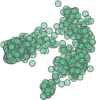

In [138]:
points

In [139]:
bounding_box = box(*points.bounds)
bounding_box = affinity.scale(bounding_box, xfact=1.2, yfact=1.2)

In [656]:
bounding_box.exterior.xy

(array('d', [0.33320923234087557, 0.33320923234087557, -0.3197471255953628, -0.3197471255953628, 0.33320923234087557]),
 array('d', [-0.33075764947823516, 0.3516880580863517, 0.3516880580863517, -0.33075764947823516, -0.33075764947823516]))

In [140]:
polygons = voronoi_polygons(points)

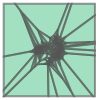

In [141]:
polygons

In [142]:
color_space = reduce_dimensions(embeddings,3)
color_space = (color_space-np.min(color_space))/(np.max(color_space)-np.min(color_space))

In [114]:
hsv_colors = [colorsys.rgb_to_hsv(*color) for color in color_space]
tweaked_colors = [colorsys.hsv_to_rgb(hue, saturation/2, 1-((1-value)/1.25)) for hue,saturation,value in hsv_colors]

In [115]:
# 1D color space, hue-only, saturation and value are constants
color_space_1d = reduce_dimensions(embeddings,1)
color_space_1d = (color_space_1d-np.min(color_space_1d))/(np.max(color_space_1d)-np.min(color_space_1d))
color_space_1d = [colorsys.hsv_to_rgb(hue[0]/1.3, 0.25, 0.85) for hue in color_space_1d]

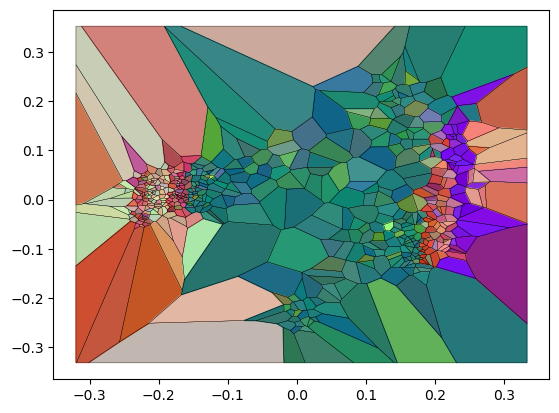

In [116]:
for i, polygon in enumerate(polygons.geoms):
    clipped_polygon = polygon.intersection(bounding_box)
    plt.plot(*clipped_polygon.exterior.xy, c='black', linewidth=0.2)
    plt.fill(*clipped_polygon.exterior.xy, c=color_space[i])
plt.show()

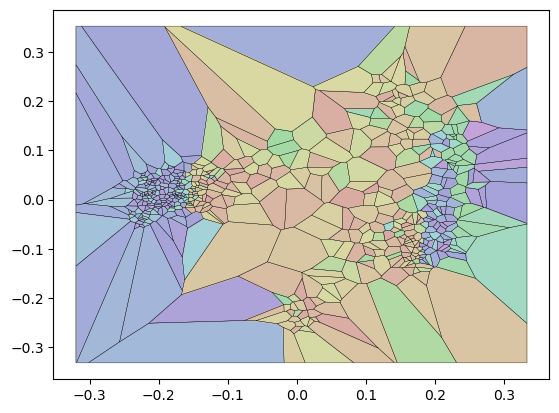

In [117]:
for i, polygon in enumerate(polygons.geoms):
    clipped_polygon = polygon.intersection(bounding_box)
    plt.plot(*clipped_polygon.exterior.xy, c='black', linewidth=0.2)
    plt.fill(*clipped_polygon.exterior.xy, c=color_space_1d[i])
plt.show()

In [ ]:
###
### Experimenting
###

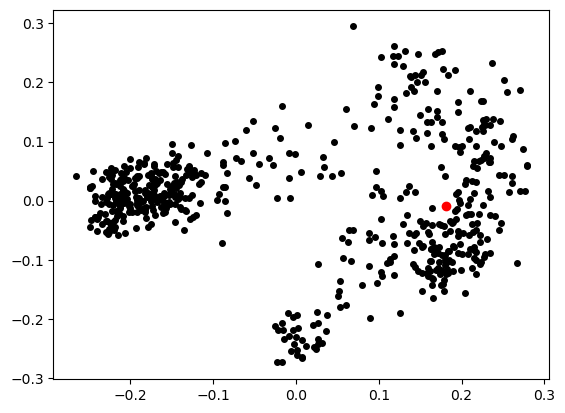

In [614]:
center = latent_space[0]
other = latent_space[1:]

plt.plot(*center, marker="o", markersize=6, markeredgecolor='red', markerfacecolor='red')
for point in other:
    plt.plot(*point, marker="o", markersize=4, markeredgecolor='black', markerfacecolor='black')
plt.show()

In [120]:
nodes = [tree]
weights = []

while len(nodes) != 0:
    new_nodes = []
    for node in nodes:
        if node.left and node.right:
            weights.append(abs(node.left.get_children() - node.right.get_children()))
            new_nodes.append(node.left)
            new_nodes.append(node.right)
    nodes = new_nodes

In [121]:
max(weights)

592

In [186]:
def weight(left, right):
    comparison = (left.get_children() - right.get_children()) / max(weights)
    comparison *= 0.8
    if comparison > 0: comparison += 0.1
    elif comparison < 0: comparison -= 0.1
    return comparison

In [187]:
def centroid(tree):
    points = np.empty((tree.get_children(),2))
    for i, filename in enumerate(tree.files):
        idx = embedding_labels.index(filename)
        points[i] = latent_space[idx]
    return points.mean(axis=0)

In [188]:
centroids = np.array([centroid(tree.left), centroid(tree.right)])

In [189]:
centroids

array([[ 1.79365463e-01, -5.65087437e-02],
       [-3.02471269e-04,  9.52929911e-05]])

In [190]:
weight(tree.left, tree.right)

-0.9

In [634]:
# For rendering a level of the binary tree as weighted voronoi cells, not the leaves since those are handled seperately at the end
def voronoi_partition(tree_left, tree_right, bounding_box, bounding_polygon):
    w = weight(tree_left, tree_right)
    centroids = np.array([centroid(tree_left), centroid(tree_right)])
    x = centroids[:,0]
    y = centroids[:,1]
    if x[0] > x[1]: # numpy interp() is apparently not very smart and returns nonsense results if the line created by interpolating points has a negative slope
        x[0], x[1] = x[1], x[0]
        y[0], y[1] = y[1], y[0]
    dx = abs(x[0] - x[1])
    base = min(x[0], x[1])
    if w > 0: # move in a different direction depending on which centroid has more documents in it
        centroids[0] = [base+w*dx, np.interp(w*dx, x, y)]
    elif w < 0:
        centroids[1] = [base+(1-w)*dx, np.interp((1-w)*dx, x, y)]
    points = MultiPoint(centroids)
    print(bounding_box)
    polygons = voronoi_diagram(points, envelope=bounding_box).geoms
    #if bounding_polygon:
    #    polygons_clipped = []
    #    for polygon in polygons:
    #        polygons_clipped.append(polygon.intersection(bounding_polygon))
    #    polygons = polygons_clipped
    return polygons, abs(w)

In [635]:
def _voronoi_first_pass(tree, bounding_box, bounding_polygon=None, depth=0, max_depth=1):
    boundaries = []
    leaves = []
    centroids = []
    if depth > max_depth: return boundaries, leaves, centroids
    if tree.left != None and tree.right != None:
        polygons, w = voronoi_partition(tree.left, tree.right, bounding_box, bounding_polygon)
        for polygon in polygons:
            if not polygon.is_empty:
                boundaries.append((polygon,w))
        c_l = centroid(tree.left)
        c_r = centroid(tree.right)
        l_boundaries, l_leaves, l_c = _voronoi_first_pass(tree.left, bounding_box, polygons[0], depth+1, max_depth)
        r_boundaries, r_leaves, r_c = _voronoi_first_pass(tree.right, bounding_box, polygons[1], depth+1, max_depth)
        if len(l_c): centroids.extend(l_c)
        else: centroids.append(c_l)
        if len(r_c): centroids.extend(r_c)
        else: centroids.append(c_r)
        boundaries.extend(l_boundaries)
        boundaries.extend(r_boundaries)
        leaves.extend(l_leaves)
        leaves.extend(r_leaves)
    else:
        leaves.append(centroid(tree))
    return boundaries, leaves, centroids

In [636]:
def _voronoi_second_pass(boundaries, leaves):
    return polygons

In [637]:
def render_voronoi(tree, bounding_box, max_depth):
    boundaries, leaves, centroids = _voronoi_first_pass(tree, bounding_box, max_depth=max_depth)
    for shape, width in boundaries:
        plt.plot(*shape.exterior.xy, c='black', linewidth=width*1.5)
    for leaf in leaves:
        plt.plot(*leaf, marker="o", markersize=6, markeredgecolor='red', markerfacecolor='red')
    for centroid in centroids:
        plt.plot(*centroid, marker="o", markersize=4, markeredgecolor='black', markerfacecolor='black')
    #polygons = _voronoi_second_pass(boundaries, leaves)
    #for i, polygon in enumerate(polygons.geoms):
    #    plt.plot(*clipped_polygon.exterior.xy, c='black', linewidth=0.2)
    #    plt.fill(*clipped_polygon.exterior.xy, c=color_space_1d[i])
    #plt.show()
    plt.show()

In [638]:
print(bounding_box)

POLYGON ((0.3332092323408756 -0.3307576494782352, 0.3332092323408756 0.3516880580863517, -0.3197471255953628 0.3516880580863517, -0.3197471255953628 -0.3307576494782352, 0.3332092323408756 -0.3307576494782352))


POLYGON ((0.3332092323408756 -0.3307576494782352, 0.3332092323408756 0.3516880580863517, -0.3197471255953628 0.3516880580863517, -0.3197471255953628 -0.3307576494782352, 0.3332092323408756 -0.3307576494782352))
POLYGON ((0.3332092323408756 -0.3307576494782352, 0.3332092323408756 0.3516880580863517, -0.3197471255953628 0.3516880580863517, -0.3197471255953628 -0.3307576494782352, 0.3332092323408756 -0.3307576494782352))
POLYGON ((0.3332092323408756 -0.3307576494782352, 0.3332092323408756 0.3516880580863517, -0.3197471255953628 0.3516880580863517, -0.3197471255953628 -0.3307576494782352, 0.3332092323408756 -0.3307576494782352))
POLYGON ((0.3332092323408756 -0.3307576494782352, 0.3332092323408756 0.3516880580863517, -0.3197471255953628 0.3516880580863517, -0.3197471255953628 -0.3307576494782352, 0.3332092323408756 -0.3307576494782352))
POLYGON ((0.3332092323408756 -0.3307576494782352, 0.3332092323408756 0.3516880580863517, -0.3197471255953628 0.3516880580863517, -0.3197471255953628 -0.3307

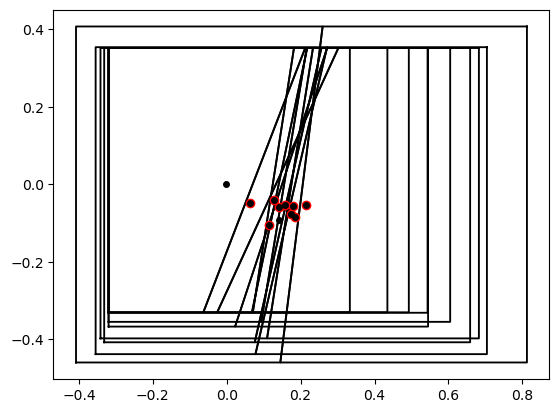

In [651]:
render_voronoi(tree, bounding_box, max_depth=9)

In [282]:
polygons, linewidth = voronoi_partition(tree.left, tree.right, bounding_box)

In [283]:
_voronoi_first_pass(tree, bounding_box)

([(<POLYGON ((-0.179 0.179, 0.155 0.179, 0.024 -0.236, -0.179 -0.236, -0.179 0....>,
   -0.9),
  (<POLYGON ((0.024 -0.236, 0.155 0.179, 0.333 0.179, 0.333 -0.236, 0.024 -0.236))>,
   -0.9),
  (<POLYGON ((0.317 -0.211, 0.032 -0.211, 0.149 0.159, 0.317 0.159, 0.317 -0.211))>,
   -0.8986486486486487),
  (<POLYGON ((0.21 0.114, 0.095 -0.011, 0.135 0.114, 0.21 0.114))>,
   -0.8972972972972973),
  (<POLYGON ((0.228 -0.211, 0.032 -0.211, 0.095 -0.011, 0.21 0.114, 0.228 0.114...>,
   -0.8972972972972973),
  (<POLYGON ((0.06 -0.211, 0.032 -0.211, 0.095 -0.011, 0.117 0.013, 0.06 -0.211))>,
   -0.895945945945946),
  (<POLYGON ((0.117 0.013, 0.21 0.114, 0.228 0.114, 0.228 -0.211, 0.06 -0.211, ...>,
   -0.895945945945946),
  (<POLYGON ((0.127 -0.113, 0.085 -0.113, 0.117 0.013, 0.127 0.024, 0.127 -0.113))>,
   -0.8945945945945946),
  (<POLYGON ((0.085 -0.113, 0.117 0.013, 0.127 0.024, 0.127 -0.113, 0.085 -0.113))>,
   -0.8932432432432432),
  (<POLYGON ((0.115 0.004, 0.117 0.013, 0.121 0.017, 0.115 0

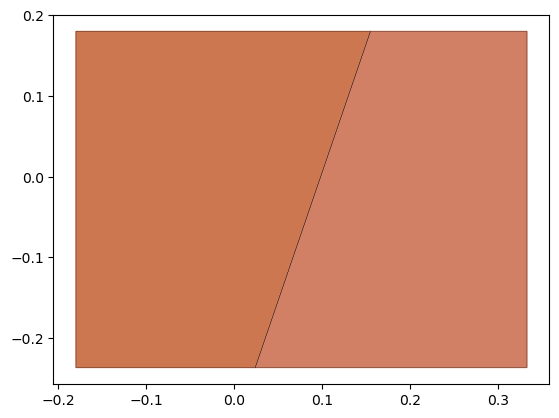

In [71]:
nodes = [tree]
depth = 0

while len(nodes) != 0:
    new_nodes = []
    for node in nodes:
        if node.left: new_nodes.append(node.left)
        if node.right: new_nodes.append(node.right)
    nodes = new_nodes
    depth += 1
    
    centroids = all_centroids[depth]
    points = []
    for i, node in enumerate(nodes):
        weight = node.get_children()
        centroid = centroids[i]
    
    points = MultiPoint(centroids)
    polygons = voronoi_polygons(points)
    for i, polygon in enumerate(polygons.geoms):
        clipped_polygon = polygon.intersection(bounding_box)
        plt.plot(*clipped_polygon.exterior.xy, c='black', linewidth=0.2)
        plt.fill(*clipped_polygon.exterior.xy, c=color_space[i])
    break
    
plt.show()

In [45]:
clusters2 = np.load('clusters.npz', allow_pickle=True)